In [212]:
import numpy as np 
import pandas as pd
import datetime as dt 
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from warnings import filterwarnings
from pandas.tseries.offsets import YearEnd
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from tqdm import tqdm
from matplotlib import gridspec

filterwarnings('ignore')

## 데이터 로딩 페이지

In [213]:
def cal_mdd (ret_df):
    
    cum = ((ret_df+1).cumprod())
    p = np.maximum.accumulate(cum)
    dd = (cum-p)/(p)
    return dd

In [214]:
'''월간 수익률'''

#df_ret = pd.read_pickle('./DATA/real_ret.pkl').resample('m').last()
df      = pd.read_pickle('./DATA/kospi_adj_close.pkl').astype(float).resample('m').last()

df_eq = pd.read_pickle('./DATA/BE.pkl').resample('m').last().iloc[:-1]
df_cap = pd.read_pickle('./DATA/kospi_capital_tmp.pkl').resample('m').last()
df_cap = df_cap.loc[df_eq.index]

df_info = pd.read_pickle('./DATA/real_kospi_info.pkl')
df_code = pd.read_pickle('./DATA/real_kospi_code.pkl')

rf = pd.read_csv('./DATA/CD91.csv', index_col=0, parse_dates=True).apply(lambda x : x/100).resample('m').last()

## 필터링 페이지

In [215]:
def filtering_penny (series):
    
    return np.where(series > 1000, series, np.NaN)

df_close_daily = df.apply(lambda x: filtering_penny(x), axis=0)
df_ret = df_close_daily.pct_change().iloc[:-1].replace(0, np.NaN)

df_ret = df_ret * df_info.replace('유가증권시장', 1).replace('비상장', np.NaN).replace('코스닥', np.NaN).replace('K-OTC', np.NaN).astype(float)
df_ret = df_ret * pd.DataFrame(np.where(df_code == 'K', 0, 1.0), index=df_code.index, columns=df_code.columns)
df_ret = df_ret.replace(0, np.NaN)

df_mom_1 = df_ret.shift(1).rolling(11).apply(lambda x : (1+x).prod()-1).replace(0, np.NaN)
df_mom_1 = df_mom_1.iloc[16:]

In [216]:
pnl_ret_list  = []
ivst_idx_list = []
long_tick_list = []
short_tick_list = []
s_ret_list = []
l_ret_list = []

for num in range(len(df_mom_1)-1):
    series = df_mom_1.iloc[num].dropna()

    date_idx = series.name
    ivst_idx = df_ret.index[np.where(df_ret.index==date_idx)[0][0] + 1]

    long_tick = series[series > series.quantile(0.9)].index.to_list()
    short_tick = series[series < series.quantile(0.1)].index.to_list()
    #short_tick = series[series < series.quantile(0.2)].index.to_list()

    long_ret = df_ret.loc[ivst_idx, long_tick].mean()
    short_ret = df_ret.loc[ivst_idx, short_tick].mean()
        
    pnl_ret = df_ret.loc[ivst_idx, long_tick].mean() - df_ret.loc[ivst_idx, short_tick].mean()
        
    pnl_ret_list.append(pnl_ret)
    ivst_idx_list.append(ivst_idx)
    long_tick_list.append(long_tick)
    short_tick_list.append(short_tick)
    s_ret_list.append(short_ret)
    l_ret_list.append(long_ret)
    

mom_pnl = pd.DataFrame(index=ivst_idx_list, \
                       data=pd.DataFrame([pnl_ret_list, long_tick_list, short_tick_list, s_ret_list, l_ret_list]).T.values,\
                       columns=['mom_pnl', 'long_idx', 'short_idx', 's_ret', 'l_ret'])

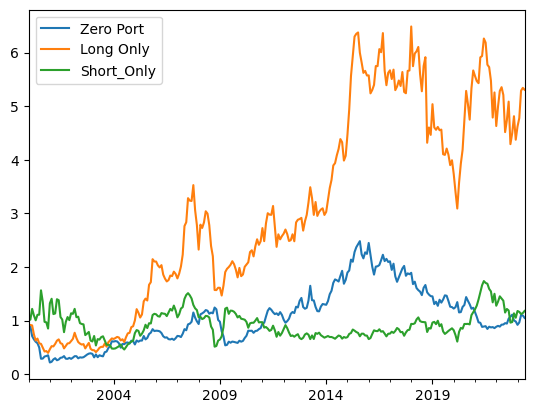

In [217]:
(mom_pnl.iloc[:,0].loc['2000':]+1).cumprod().plot()
(mom_pnl.iloc[:,4].loc['2000':]+1).cumprod().plot()
(mom_pnl.iloc[:,3].loc['2000':]+1).cumprod().plot()
plt.legend(['Zero Port', 'Long Only', 'Short_Only'])

## Decile별 뽑기

In [218]:

mom_ret_filtered = df_mom_1.loc['2000':]
monthly_ret_filtered = df_ret.loc['2000':]

reg_table = pd.DataFrame(index=np.arange(0, 10)+1, columns=['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe'])

for decile_num, x in tqdm(enumerate(zip(np.linspace(0, 1, 11)[:-1][::-1], np.linspace(0, 1, 11)[1:][::-1]))):
    
    decile_num = decile_num+1
    low_line, up_line = x[0], x[1]
    
    pnl_ret_list  = []
    ivst_idx_list = []
    long_tick_list = []
    short_tick_list = []
    s_ret_list = []
    l_ret_list = []

    for num in range(len(mom_ret_filtered)-1):
        series = mom_ret_filtered.iloc[num]

        date_idx = series.name
        ivst_idx = monthly_ret_filtered.index[np.where(monthly_ret_filtered.index==date_idx)[0][0] + 1]

        long_tick = series[(series > series.quantile(low_line)) & (series <= series.quantile(up_line))].index.to_list()
        short_tick = series[series < series.quantile(0.1)].index.to_list()
        #short_tick = series[series < series.quantile(0.2)].index.to_list()

        long_ret = monthly_ret_filtered.loc[ivst_idx, long_tick].mean()
        short_ret = monthly_ret_filtered.loc[ivst_idx, short_tick].mean()
            
        pnl_ret = long_ret - 0 #- short_ret
            
        pnl_ret_list.append(pnl_ret)
        ivst_idx_list.append(ivst_idx)
        long_tick_list.append(long_tick)
        short_tick_list.append(short_tick)
        s_ret_list.append(short_ret)
        l_ret_list.append(long_ret)
        

    mom_pnl_filtered = pd.DataFrame(index=ivst_idx_list, \
                        data=pd.DataFrame([pnl_ret_list, long_tick_list, short_tick_list, s_ret_list, l_ret_list]).T.values,\
                        columns=['mom_pnl', 'long_idx', 'short_idx', 's_ret', 'l_ret'])

    cum_ret = ((mom_pnl_filtered.iloc[:,0]+1).cumprod()-1)[-1]
    ann_ret = np.round(mom_pnl_filtered.iloc[:,0].mean() * 12 * 100, 2)
    ann_std = np.round(mom_pnl_filtered.iloc[:,0].std() * np.sqrt(12) * 100, 2)
    
    #sharpe = ((mom_pnl_filtered.iloc[:,[0]] - rf.loc[mom_pnl_filtered.index].apply(lambda x: x/12).to_numpy()).mean()/mom_pnl_filtered.iloc[:,[0]].std()).item()
    
    # reg_table.loc[decile_num, ['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe']] = [cum_ret, ann_ret, ann_std, sharpe]
    reg_table.loc[decile_num, ['CumRet', 'AnnRet(%)', 'AnnStd(%)']] = [cum_ret, ann_ret, ann_std]

10it [00:04,  2.46it/s]


In [219]:
reg_table

,CumRet,AnnRet(%),AnnStd(%),sharpe
1,4.763005,11.72,28.88,NaN
2,14.844342,14.94,24.74,NaN
3,31.362823,17.72,23.42,NaN
4,29.105007,17.45,23.58,NaN
5,17.811041,15.21,22.66,NaN
6,9.756545,12.75,22.41,NaN
7,6.638432,11.5,23.24,NaN
8,7.317112,12.48,25.82,NaN
9,1.738226,8.0,27.09,NaN
10,-0.019119,5.97,35.21,NaN


## SMB, HML Port로 비교

In [221]:
'''날짜 건들면 손모가지 날아가분다잉'''
time_idx = df_ret.loc['1991-04-01':].index

monthly_ret = df_ret.loc[time_idx]
'''SMB 이슈로 일케 함'''
#m_ret = np.log(df_close_daily).resample('m').last().diff().iloc[1:].loc[time_idx]

'SMB 이슈로 일케 함'

In [222]:

df_eq = df_eq * df_info.replace('유가증권시장', 1).replace('비상장', np.NaN).replace('코스닥', np.NaN).replace('K-OTC', np.NaN).astype(float)
df_eq = df_eq * pd.DataFrame(np.where(df_code == 'K', 0, 1.0), index=df_code.index, columns=df_code.columns)

df_cap = df_cap * df_info.replace('유가증권시장', 1).replace('비상장', np.NaN).replace('코스닥', np.NaN).replace('K-OTC', np.NaN).astype(float)
df_cap = df_cap * pd.DataFrame(np.where(df_code == 'K', 0, 1.0), index=df_code.index, columns=df_code.columns)


value_ratio = (df_eq/df_cap)

'''Cap의 중간'''
small = df_cap.apply(lambda x: x.replace(0, np.NaN).dropna()[x.replace(0, np.NaN).dropna()<x.replace(0, np.NaN).dropna().median()].index.to_list(), axis=1).dropna().loc[time_idx]
big = df_cap.apply(lambda x: x.replace(0, np.NaN).dropna()[x.replace(0, np.NaN).dropna()>=x.replace(0, np.NaN).dropna().median()].index.to_list(), axis=1).dropna().loc[time_idx]

'''가치는 equity/cap 한 것을 가지고 만듦'''
growth = value_ratio.apply(lambda x: x.replace(0, np.NaN).dropna()[x.replace(0, np.NaN).dropna()<x.replace(0, np.NaN).dropna().quantile(0.3)].index.to_list(), axis=1).dropna().loc[time_idx]
neutral = value_ratio.apply(lambda x: x.replace(0, np.NaN).dropna()[(x.replace(0, np.NaN).dropna()>=x.replace(0, np.NaN).dropna().quantile(0.3))& x.replace(0, np.NaN).dropna()<x.replace(0, np.NaN).dropna().quantile(0.7)].index.to_list(), axis=1).dropna().loc[time_idx]
value = value_ratio.apply(lambda x: x.replace(0, np.NaN).dropna()[x.replace(0, np.NaN).dropna()>=x.replace(0, np.NaN).dropna().quantile(0.7)].index.to_list(), axis=1).dropna().loc[time_idx]

SMB_list = []
HML_list = []
idx_list = []

for idx in tqdm(monthly_ret.index):
    
    idx_list.append(idx)
    
    '''equal'''

    # bv = monthly_ret.loc[idx].loc[list(set(big.loc[idx]) & set(value.loc[idx]))].mean()
    # bn = monthly_ret.loc[idx].loc[list(set(big.loc[idx]) & set(neutral.loc[idx]))].mean()
    # bg = monthly_ret.loc[idx].loc[list(set(big.loc[idx]) & set(growth.loc[idx]))].mean()
    # sv = monthly_ret.loc[idx].loc[list(set(small.loc[idx]) & set(value.loc[idx]))].mean()
    # sn = monthly_ret.loc[idx].loc[list(set(small.loc[idx]) & set(neutral.loc[idx]))].mean()
    # sg = monthly_ret.loc[idx].loc[list(set(small.loc[idx]) & set(growth.loc[idx]))].mean()
    
    '''Value Weight'''
    
    bv = (monthly_ret.loc[idx].loc[list(set(big.loc[idx]) & set(value.loc[idx]))] * \
                        df_cap[list(set(big.loc[idx]) & set(value.loc[idx]))].loc[idx]/df_cap[list(set(big.loc[idx]) & set(value.loc[idx]))].loc[idx].sum()).sum()
    bn = (monthly_ret.loc[idx].loc[list(set(big.loc[idx]) & set(neutral.loc[idx]))] * \
                        df_cap[list(set(big.loc[idx]) & set(neutral.loc[idx]))].loc[idx]/df_cap[list(set(big.loc[idx]) & set(neutral.loc[idx]))].loc[idx].sum()).sum()
    bg = (monthly_ret.loc[idx].loc[list(set(big.loc[idx]) & set(growth.loc[idx]))] * \
                        df_cap[list(set(big.loc[idx]) & set(growth.loc[idx]))].loc[idx]/df_cap[list(set(big.loc[idx]) & set(growth.loc[idx]))].loc[idx].sum()).sum()
    sv = (monthly_ret.loc[idx].loc[list(set(small.loc[idx]) & set(value.loc[idx]))] * \
                        df_cap[list(set(small.loc[idx]) & set(value.loc[idx]))].loc[idx]/df_cap[list(set(small.loc[idx]) & set(value.loc[idx]))].loc[idx].sum()).sum()
    sn = (monthly_ret.loc[idx].loc[list(set(small.loc[idx]) & set(neutral.loc[idx]))] * \
                        df_cap[list(set(small.loc[idx]) & set(neutral.loc[idx]))].loc[idx]/df_cap[list(set(small.loc[idx]) & set(neutral.loc[idx]))].loc[idx].sum()).sum()
    sg = (monthly_ret.loc[idx].loc[list(set(small.loc[idx]) & set(growth.loc[idx]))] * \
                        df_cap[list(set(small.loc[idx]) & set(growth.loc[idx]))].loc[idx]/df_cap[list(set(small.loc[idx]) & set(growth.loc[idx]))].loc[idx].sum()).sum()
    
    

    SMB = (sv+sn+sg)/3 - (bv+bn+bg)/3
    HML = (sv+bv)/2 - (sg+bg)/2
    
    SMB_list.append(SMB)
    HML_list.append(HML)


rf = pd.read_csv('./DATA/CD91.csv', index_col=0, parse_dates=True).apply(lambda x : x/100).resample('m').last()

SMB = pd.DataFrame(SMB_list, index=monthly_ret.index, columns=['SMB']).dropna().loc[rf.index[0]:]
#SMB = pd.DataFrame(pd.concat([SMB, rf], axis=1).dropna().apply(lambda x: x[0]-x[1]/12, axis=1), columns=['SMB'])

HML = pd.DataFrame(HML_list, index=monthly_ret.index, columns=['HML']).dropna().loc[rf.index[0]:]
#HML = pd.DataFrame(pd.concat([HML, rf], axis=1).dropna().apply(lambda x: x[0]-x[1]/12, axis=1), columns=['HML'])

rf = rf.loc[SMB.index]

mkt = pd.read_csv('./DATA/kospi_index.csv', index_col=0, parse_dates=True).resample('m').last().pct_change().loc[SMB.index]
mkt = pd.DataFrame(pd.concat([mkt, rf], axis=1).dropna().apply(lambda x: x[0]-x[1]/12, axis=1), columns=['MKT'])

pd.DataFrame(np.array([[  mkt.mean().item()*12, SMB.mean().item()*12, HML.mean().item()*12 ],
                       [  mkt.std().item()*np.sqrt(12), SMB.std().item()*np.sqrt(12), HML.std().item()*np.sqrt(12) ]]),
             index=['AnnRet', 'Vol'],
             columns=['MKT', 'SMB', 'HML'])

100%|██████████| 386/386 [00:02<00:00, 149.52it/s]


,MKT,SMB,HML
AnnRet,0.013591,-0.060095,-0.300929
Vol,0.263959,0.211090,0.192998


<AxesSubplot:>

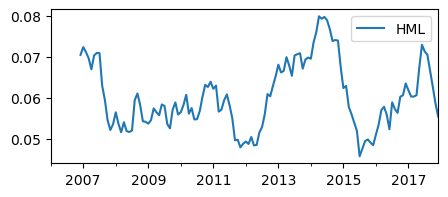

In [223]:
HML.loc['2006-01':'2017'].rolling(12).apply(lambda x: (1+x).prod()).apply(lambda x: x/12).plot(figsize=(5,2))

## Rolling Regression

In [224]:
resid_list = []

#monthly_ret = df_close_daily.resample('m').last().pct_change().iloc[1:].replace(0, np.NaN)

for name in tqdm(monthly_ret.columns):

    aa = name
    exret = pd.DataFrame(pd.concat([monthly_ret[aa], rf],axis=1).dropna().apply(lambda x: x[0] - x[1], axis=1), columns=['ExRet'])


    '''전체기간용'''
    setup_df = pd.concat([exret, mkt, SMB, HML], axis=1).dropna().iloc[35:]
    
    '''t-1~t-36롤링용'''
    setup_df_for_roll = pd.concat([exret, mkt, SMB, HML], axis=1).dropna().shift(1).dropna()
    
    y = setup_df_for_roll.iloc[:,[0]]
    y_real = setup_df.iloc[:,[0]]
    #x = sm.add_constant(setup_df_for_roll.iloc[:, 1:])
    x = setup_df_for_roll.iloc[:, 1:]
    
    try:
        reg = RollingOLS(y, x, 35).fit()

        coef_df = reg.params

        resid = (y_real - pd.DataFrame(np.diag(np.dot(setup_df.iloc[:,1:], coef_df.T)), index=setup_df.index, columns=['PRED']).values).rename(columns={'ExRet':aa})
        resid_list.append(resid)

    except:
        
        resid = pd.DataFrame(index=setup_df.index, columns=[aa])
        resid_list.append(resid)
        pass
    
resid_df = pd.concat(resid_list, axis=1)

resid_standard = resid_df.apply(lambda x: x.dropna().shift(1).rolling(11).sum()/x.dropna().shift(1).rolling(11).std(), axis=0)
resid_df

100%|██████████| 1102/1102 [00:14<00:00, 74.19it/s] 


,000010,000020,000030,000040,000050,000060,000070,000080,000100,000110,...,383220,383800,402340,403550,446070,450140,452260,453340,456040,457190
1995-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31,NaN,-0.061582,NaN,NaN,-0.085333,NaN,-0.023942,-0.076754,-0.217737,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-28,NaN,-0.064386,NaN,NaN,0.002066,NaN,0.077176,-0.123334,-0.018934,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-31,NaN,-0.057654,NaN,NaN,-0.035476,NaN,-0.024805,-0.116984,-0.092197,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-30,NaN,-0.040951,NaN,NaN,-0.031619,NaN,-0.031595,-0.043305,0.074534,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


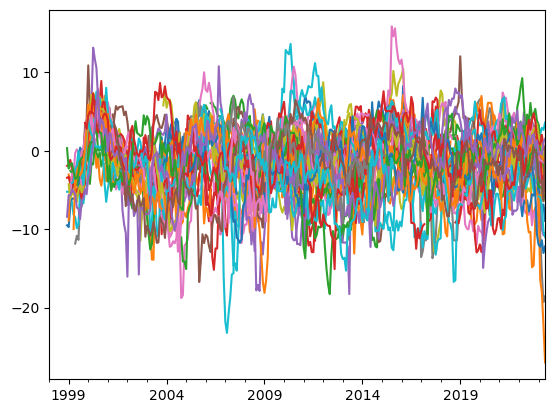

In [255]:
for x in resid_df.columns[0:50]:
    resid_standard[x].plot()

In [225]:
resid_mom_ret_list_1 = []
resid_mom_ret_date_list_1 = []
top_resid_num = []

monthly_resid = resid_standard.iloc[np.where(resid_standard.sum(axis=1) != 0)].iloc[:-1]

for sig_index in tqdm(monthly_resid.index[:-1]):
    
    '''시그널 날짜'''
    sig_index = sig_index
    
    '''투자 수익률 날짜'''
    invest_index = monthly_ret.index[np.where(monthly_ret.index == sig_index)[0] + 1][0]
    
    '''편의를 위해'''
    series = monthly_resid.loc[sig_index]
    '''종목 선정'''
    long_tick   = series[series>=series.quantile(0.9)].index
    short_tick  = series[series<=series.quantile(0.1)].index

    '''수익률 (eq weight)'''
    long_ret    = monthly_ret.loc[invest_index, long_tick].mean()
    short_ret   = monthly_ret.loc[invest_index, short_tick].mean()

    '''mom_port_ret'''
    mom_port_ret = long_ret - short_ret
    # print(invest_index)
    # print(mom_port_ret)
    # print('\n')
    '''저장'''
    resid_mom_ret_date_list_1.append(invest_index)
    resid_mom_ret_list_1.append(mom_port_ret)

    '''이외 디버깅'''
    top_resid_num.append(len(long_tick))

print(monthly_resid.index[0])

100%|██████████| 292/292 [00:00<00:00, 1016.21it/s]

1998-12-31 00:00:00


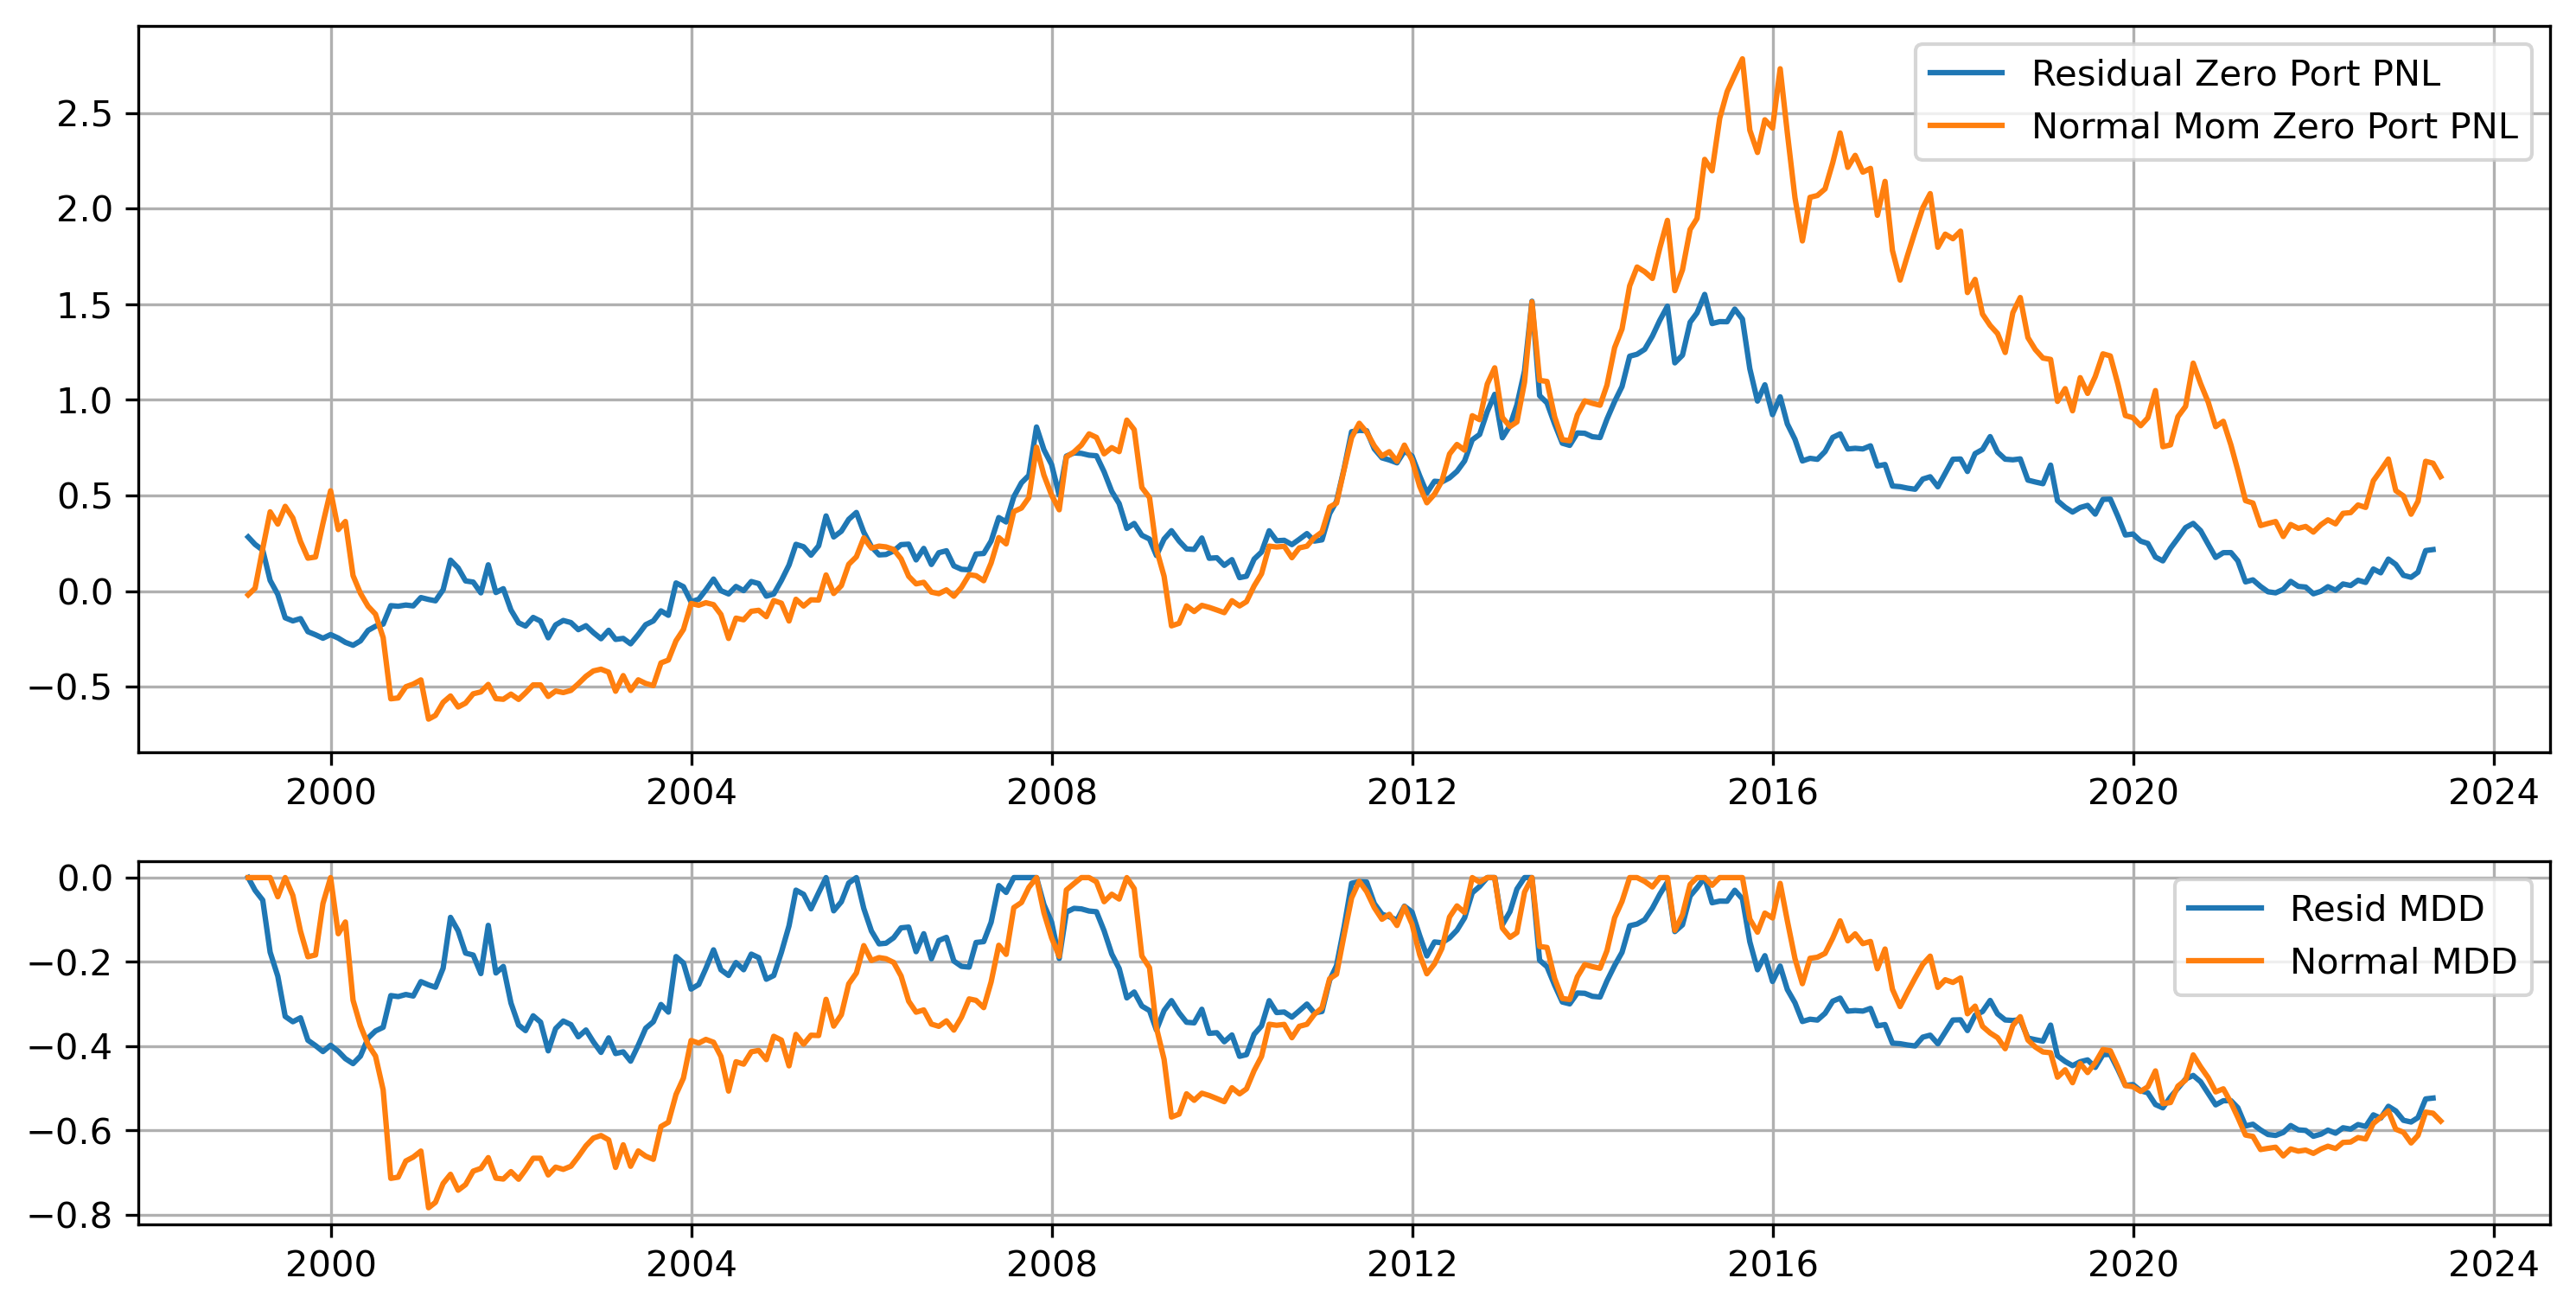

In [226]:
resid_mom_ret = pd.DataFrame(index=resid_mom_ret_date_list_1, data=resid_mom_ret_list_1, columns=['Residual Mom Return?']).dropna()

fig = plt.figure(figsize=(12,6), dpi=300)

spec = gridspec.GridSpec(ncols=1, nrows=2,
                         height_ratios=[2, 1])

ax0 = fig.add_subplot(spec[0])
ax0.plot((resid_mom_ret + 1).cumprod()-1, label='Residual Zero Port PNL')
ax0.plot((mom_pnl.loc[resid_mom_ret.index[0]:, 'mom_pnl']+1).cumprod()-1, label='Normal Mom Zero Port PNL')
ax0.grid()
ax0.legend()

ax1 = fig.add_subplot(spec[1])
ax1.plot(cal_mdd(resid_mom_ret), label='Resid MDD')
ax1.plot(cal_mdd(mom_pnl.loc[resid_mom_ret.index[0]:, 'mom_pnl']), label='Normal MDD')
ax1.legend()
ax1.grid()

fig.show()


In [227]:
resid_mom_ret.index[0]

Timestamp('1999-01-31 00:00:00')

# 1. PRET(12,1)

- Rolling 시작일 '1991-04-01' <br>
- 그냥 Momentum 시작일은 '1999-01-01' <br>

In [230]:
df_mom_1 = df_ret.shift(1).rolling(11).apply(lambda x : (1+x).prod()-1).replace(0, np.NaN)
df_mom_1 = df_mom_1.iloc[16:]

mom_ret_filtered = df_mom_1.loc['1999':]
monthly_ret_filtered = df_ret.loc['1999':]

reg_table = pd.DataFrame(index=np.arange(0, 10)+1, columns=['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe'])

for decile_num, x in tqdm(enumerate(zip(np.linspace(0, 1, 11)[:-1][::-1], np.linspace(0, 1, 11)[1:][::-1]))):
    
    decile_num = decile_num+1
    low_line, up_line = x[0], x[1]
    
    pnl_ret_list  = []
    ivst_idx_list = []
    long_tick_list = []
    short_tick_list = []
    s_ret_list = []
    l_ret_list = []

    for num in range(len(mom_ret_filtered)-1):
        series = mom_ret_filtered.iloc[num]

        date_idx = series.name
        ivst_idx = monthly_ret_filtered.index[np.where(monthly_ret_filtered.index==date_idx)[0][0] + 1]

        long_tick = series[(series > series.quantile(low_line)) & (series <= series.quantile(up_line))].index.to_list()
        short_tick = series[series < series.quantile(0.1)].index.to_list()
        #short_tick = series[series < series.quantile(0.2)].index.to_list()

        long_ret = monthly_ret_filtered.loc[ivst_idx, long_tick].mean()
        short_ret = monthly_ret_filtered.loc[ivst_idx, short_tick].mean()
            
        pnl_ret = long_ret - 0 #- short_ret
            
        pnl_ret_list.append(pnl_ret)
        ivst_idx_list.append(ivst_idx)
        long_tick_list.append(long_tick)
        short_tick_list.append(short_tick)
        s_ret_list.append(short_ret)
        l_ret_list.append(long_ret)
        

    mom_pnl_filtered = pd.DataFrame(index=ivst_idx_list, \
                        data=pd.DataFrame([pnl_ret_list, long_tick_list, short_tick_list, s_ret_list, l_ret_list]).T.values,\
                        columns=['mom_pnl', 'long_idx', 'short_idx', 's_ret', 'l_ret'])

    cum_ret = ((mom_pnl_filtered.iloc[:,0]+1).cumprod()-1)[-1]
    ann_ret = np.round(mom_pnl_filtered.iloc[:,0].mean() * 12 * 100, 2)
    ann_std = np.round(mom_pnl_filtered.iloc[:,0].std() * np.sqrt(12) * 100, 2)
    
    sharpe = (mom_pnl_filtered.iloc[:,[0]].mean()/mom_pnl_filtered.iloc[:,[0]].std()).item()
    
    reg_table.loc[decile_num, ['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe']] = [cum_ret, ann_ret, ann_std, sharpe]
    #reg_table.loc[decile_num, ['CumRet', 'AnnRet(%)', 'AnnStd(%)']] = [cum_ret, ann_ret, ann_std]

10it [00:03,  2.59it/s]


In [231]:
reg_table

,CumRet,AnnRet(%),AnnStd(%),sharpe
1,4.871842,11.69,29.63,0.11386
2,13.938103,14.47,25.87,0.161548
3,42.06013,18.51,24.4,0.219013
4,32.187173,17.42,24.43,0.205868
5,26.005107,16.4,23.65,0.200157
6,11.749278,13.27,23.54,0.162676
7,7.976529,12.04,24.36,0.14267
8,6.242205,11.7,26.5,0.127411
9,1.395199,7.34,27.36,0.077456
10,-0.271542,4.77,35.22,0.039139


In [232]:
monthly_resid = resid_standard.iloc[np.where(resid_standard.sum(axis=1) != 0)].iloc[:-1]

reg_table_resid_1 = pd.DataFrame(index=np.arange(0, 10)+1, columns=['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe'])

for decile_num, x in tqdm(enumerate(zip(np.linspace(0, 1, 11)[:-1][::-1], np.linspace(0, 1, 11)[1:][::-1]))):

    decile_num = decile_num+1
    low_line, up_line = x[0], x[1]

    resid_mom_ret_list_1 = []
    resid_mom_ret_date_list_1 = []
    top_resid_num = []

    for sig_index in monthly_resid.index[:-1]:
        
        '''시그널 날짜'''
        sig_index = sig_index
        
        '''투자 수익률 날짜'''
        invest_index = monthly_ret.index[np.where(monthly_ret.index == sig_index)[0] + 1][0]
        
        '''편의를 위해'''
        series = monthly_resid.loc[sig_index]
        
        '''종목 선정'''
        long_tick = series[(series > series.quantile(low_line)) & (series <= series.quantile(up_line))].index.to_list()
        short_tick = series[series < series.quantile(0.1)].index.to_list()

        '''수익률 (eq weight)'''
        long_ret    = monthly_ret.loc[invest_index, long_tick].mean()
        short_ret   = monthly_ret.loc[invest_index, short_tick].mean()

        '''mom_port_ret'''
        mom_port_ret = long_ret# - short_ret
        # print(invest_index)
        # print(mom_port_ret)
        # print('\n')
        '''저장'''
        resid_mom_ret_date_list_1.append(invest_index)
        resid_mom_ret_list_1.append(mom_port_ret)


    resid_mom_ret = pd.DataFrame(index=resid_mom_ret_date_list_1, data=resid_mom_ret_list_1, columns=['Residual Mom Return?']).dropna()


    cum_ret = ((resid_mom_ret.iloc[:,0]+1).cumprod()-1)[-1]
    ann_ret = np.round(resid_mom_ret.iloc[:,0].mean() * 12 * 100, 2)
    ann_std = np.round(resid_mom_ret.iloc[:,0].std() * np.sqrt(12) * 100, 2)
    
    sharpe = (resid_mom_ret.iloc[:,[0]].mean()/resid_mom_ret.iloc[:,[0]].std()).item()
    
    reg_table_resid_1.loc[decile_num, ['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe']] = [cum_ret, ann_ret, ann_std, sharpe]

reg_table_resid_1

10it [00:03,  2.53it/s]


,CumRet,AnnRet(%),AnnStd(%),sharpe
1,15.627673,16.14,30.23,0.154117
2,13.091757,14.83,28.03,0.152711
3,21.701277,16.41,26.53,0.178573
4,25.700063,17.16,26.84,0.184517
5,25.455859,17.1,26.94,0.183215
6,18.465118,15.56,25.77,0.174313
7,18.394389,15.89,27.58,0.166329
8,6.785,11.66,25.21,0.13356
9,12.126975,13.97,26.18,0.154122
10,9.661342,13.21,26.28,0.145135


# 2. PRET(12,7)

- Rolling 시작일 '1991-04-01' <br>
- 그냥 Momentum 시작일은 '1999-01-01' <br>

In [233]:
df_mom_2 = df_ret.shift(7).rolling(5).apply(lambda x : (1+x).prod()-1).replace(0, np.NaN)
df_mom_2 = df_mom_2.iloc[16:]

mom_ret_filtered = df_mom_2.loc['1999':]
monthly_ret_filtered = df_ret.loc['1999':]

reg_table_2 = pd.DataFrame(index=np.arange(0, 10)+1, columns=['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe'])

for decile_num, x in tqdm(enumerate(zip(np.linspace(0, 1, 11)[:-1][::-1], np.linspace(0, 1, 11)[1:][::-1]))):
    
    decile_num = decile_num+1
    low_line, up_line = x[0], x[1]
    
    pnl_ret_list  = []
    ivst_idx_list = []
    long_tick_list = []
    short_tick_list = []
    s_ret_list = []
    l_ret_list = []

    for num in range(len(mom_ret_filtered)-1):
        series = mom_ret_filtered.iloc[num]

        date_idx = series.name
        ivst_idx = monthly_ret_filtered.index[np.where(monthly_ret_filtered.index==date_idx)[0][0] + 1]

        long_tick = series[(series > series.quantile(low_line)) & (series <= series.quantile(up_line))].index.to_list()
        short_tick = series[series < series.quantile(0.1)].index.to_list()
        #short_tick = series[series < series.quantile(0.2)].index.to_list()

        long_ret = monthly_ret_filtered.loc[ivst_idx, long_tick].mean()
        short_ret = monthly_ret_filtered.loc[ivst_idx, short_tick].mean()
            
        pnl_ret = long_ret - 0 #- short_ret
            
        pnl_ret_list.append(pnl_ret)
        ivst_idx_list.append(ivst_idx)
        long_tick_list.append(long_tick)
        short_tick_list.append(short_tick)
        s_ret_list.append(short_ret)
        l_ret_list.append(long_ret)
        

    mom_pnl_filtered = pd.DataFrame(index=ivst_idx_list, \
                        data=pd.DataFrame([pnl_ret_list, long_tick_list, short_tick_list, s_ret_list, l_ret_list]).T.values,\
                        columns=['mom_pnl', 'long_idx', 'short_idx', 's_ret', 'l_ret'])

    cum_ret = ((mom_pnl_filtered.iloc[:,0]+1).cumprod()-1)[-1]
    ann_ret = np.round(mom_pnl_filtered.iloc[:,0].mean() * 12 * 100, 2)
    ann_std = np.round(mom_pnl_filtered.iloc[:,0].std() * np.sqrt(12) * 100, 2)
    
    sharpe = (mom_pnl_filtered.iloc[:,[0]].mean()/mom_pnl_filtered.iloc[:,[0]].std()).item()
    
    reg_table_2.loc[decile_num, ['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe']] = [cum_ret, ann_ret, ann_std, sharpe]
    #reg_table.loc[decile_num, ['CumRet', 'AnnRet(%)', 'AnnStd(%)']] = [cum_ret, ann_ret, ann_std]
reg_table_2

10it [00:03,  2.55it/s]


,CumRet,AnnRet(%),AnnStd(%),sharpe
1,4.443868,11.14,28.7,0.112036
2,18.728793,15.45,24.99,0.178403
3,15.834755,14.7,24.75,0.171413
4,27.62223,16.75,24.15,0.200257
5,15.825731,14.51,23.97,0.17478
6,31.408026,17.29,24.18,0.206377
7,22.042837,16.24,25.79,0.181737
8,12.051004,13.98,26.06,0.154831
9,2.987078,9.41,27.14,0.100064
10,-0.317611,3.49,31.91,0.031548


In [234]:
resid_standard_2 = resid_df.apply(lambda x: x.dropna().shift(7).rolling(5).sum()/x.dropna().shift(7).rolling(5).std(), axis=0)

monthly_resid = resid_standard_2.iloc[np.where(resid_standard_2.sum(axis=1) != 0)].iloc[:-1]

reg_table_resid_2 = pd.DataFrame(index=np.arange(0, 10)+1, columns=['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe'])

for decile_num, x in tqdm(enumerate(zip(np.linspace(0, 1, 11)[:-1][::-1], np.linspace(0, 1, 11)[1:][::-1]))):

    decile_num = decile_num+1
    low_line, up_line = x[0], x[1]

    resid_mom_ret_list_1 = []
    resid_mom_ret_date_list_1 = []
    top_resid_num = []

    for sig_index in monthly_resid.index[:-1]:
        
        '''시그널 날짜'''
        sig_index = sig_index
        
        '''투자 수익률 날짜'''
        invest_index = monthly_ret.index[np.where(monthly_ret.index == sig_index)[0] + 1][0]
        
        '''편의를 위해'''
        series = monthly_resid.loc[sig_index]
        
        '''종목 선정'''
        long_tick = series[(series > series.quantile(low_line)) & (series <= series.quantile(up_line))].index.to_list()
        short_tick = series[series < series.quantile(0.1)].index.to_list()

        '''수익률 (eq weight)'''
        long_ret    = monthly_ret.loc[invest_index, long_tick].mean()
        short_ret   = monthly_ret.loc[invest_index, short_tick].mean()

        '''mom_port_ret'''
        mom_port_ret = long_ret# - short_ret
        # print(invest_index)
        # print(mom_port_ret)
        # print('\n')
        '''저장'''
        resid_mom_ret_date_list_1.append(invest_index)
        resid_mom_ret_list_1.append(mom_port_ret)


    resid_mom_ret = pd.DataFrame(index=resid_mom_ret_date_list_1, data=resid_mom_ret_list_1, columns=['Residual Mom Return?']).dropna()


    cum_ret = ((resid_mom_ret.iloc[:,0]+1).cumprod()-1)[-1]
    ann_ret = np.round(resid_mom_ret.iloc[:,0].mean() * 12 * 100, 2)
    ann_std = np.round(resid_mom_ret.iloc[:,0].std() * np.sqrt(12) * 100, 2)
    
    sharpe = (resid_mom_ret.iloc[:,[0]].mean()/resid_mom_ret.iloc[:,[0]].std()).item()
    
    reg_table_resid_2.loc[decile_num, ['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe']] = [cum_ret, ann_ret, ann_std, sharpe]

reg_table_resid_2

10it [00:03,  2.53it/s]


,CumRet,AnnRet(%),AnnStd(%),sharpe
1,40.453011,19.79,29.72,0.192275
2,27.724129,17.74,28.09,0.182344
3,17.931464,15.97,27.8,0.16577
4,14.755542,14.61,25.26,0.166993
5,18.118626,15.55,26.11,0.171984
6,15.460564,15.13,26.79,0.163063
7,23.472547,16.48,25.76,0.18465
8,9.717808,12.88,24.84,0.149718
9,11.515803,13.91,26.61,0.150912
10,4.571715,10.7,27.02,0.114314


# 3. PRET(6,1)

- Rolling 시작일 '1991-04-01' <br>
- 그냥 Momentum 시작일은 '1999-01-01' <br>

In [235]:
df_mom_3 = df_ret.shift(1).rolling(5).apply(lambda x : (1+x).prod()-1).replace(0, np.NaN)
df_mom_3 = df_mom_3.iloc[16:]

mom_ret_filtered = df_mom_3.loc['1999':]
monthly_ret_filtered = df_ret.loc['1999':]

reg_table_3 = pd.DataFrame(index=np.arange(0, 10)+1, columns=['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe'])

for decile_num, x in tqdm(enumerate(zip(np.linspace(0, 1, 11)[:-1][::-1], np.linspace(0, 1, 11)[1:][::-1]))):
    
    decile_num = decile_num+1
    low_line, up_line = x[0], x[1]
    
    pnl_ret_list  = []
    ivst_idx_list = []
    long_tick_list = []
    short_tick_list = []
    s_ret_list = []
    l_ret_list = []

    for num in range(len(mom_ret_filtered)-1):
        series = mom_ret_filtered.iloc[num]

        date_idx = series.name
        ivst_idx = monthly_ret_filtered.index[np.where(monthly_ret_filtered.index==date_idx)[0][0] + 1]

        long_tick = series[(series > series.quantile(low_line)) & (series <= series.quantile(up_line))].index.to_list()
        short_tick = series[series < series.quantile(0.1)].index.to_list()
        #short_tick = series[series < series.quantile(0.2)].index.to_list()

        long_ret = monthly_ret_filtered.loc[ivst_idx, long_tick].mean()
        short_ret = monthly_ret_filtered.loc[ivst_idx, short_tick].mean()
            
        pnl_ret = long_ret - 0 #- short_ret
            
        pnl_ret_list.append(pnl_ret)
        ivst_idx_list.append(ivst_idx)
        long_tick_list.append(long_tick)
        short_tick_list.append(short_tick)
        s_ret_list.append(short_ret)
        l_ret_list.append(long_ret)
        

    mom_pnl_filtered = pd.DataFrame(index=ivst_idx_list, \
                        data=pd.DataFrame([pnl_ret_list, long_tick_list, short_tick_list, s_ret_list, l_ret_list]).T.values,\
                        columns=['mom_pnl', 'long_idx', 'short_idx', 's_ret', 'l_ret'])

    cum_ret = ((mom_pnl_filtered.iloc[:,0]+1).cumprod()-1)[-1]
    ann_ret = np.round(mom_pnl_filtered.iloc[:,0].mean() * 12 * 100, 2)
    ann_std = np.round(mom_pnl_filtered.iloc[:,0].std() * np.sqrt(12) * 100, 2)
    
    sharpe = (mom_pnl_filtered.iloc[:,[0]].mean()/mom_pnl_filtered.iloc[:,[0]].std()).item()
    
    reg_table_3.loc[decile_num, ['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe']] = [cum_ret, ann_ret, ann_std, sharpe]
    #reg_table.loc[decile_num, ['CumRet', 'AnnRet(%)', 'AnnStd(%)']] = [cum_ret, ann_ret, ann_std]
    
reg_table_3

10it [00:03,  2.53it/s]


,CumRet,AnnRet(%),AnnStd(%),sharpe
1,0.652203,6.17,28.55,0.062369
2,14.962795,14.74,25.88,0.164427
3,28.797326,16.87,23.99,0.202993
4,37.598848,17.82,23.36,0.220146
5,8.918582,12.51,24.6,0.146858
6,11.256751,13.03,23.23,0.16197
7,10.474674,13.28,25.59,0.149811
8,8.369602,12.54,25.68,0.141033
9,6.727678,12.41,28.36,0.12637
10,2.953665,11.17,33.29,0.096825


In [236]:
resid_standard_3 = resid_df.apply(lambda x: x.dropna().shift(1).rolling(5).sum()/x.dropna().shift(1).rolling(5).std(), axis=0)

monthly_resid = resid_standard_3.iloc[np.where(resid_standard_3.sum(axis=1) != 0)].iloc[:-1]

reg_table_resid_3 = pd.DataFrame(index=np.arange(0, 10)+1, columns=['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe'])

for decile_num, x in tqdm(enumerate(zip(np.linspace(0, 1, 11)[:-1][::-1], np.linspace(0, 1, 11)[1:][::-1]))):

    decile_num = decile_num+1
    low_line, up_line = x[0], x[1]

    resid_mom_ret_list_1 = []
    resid_mom_ret_date_list_1 = []
    top_resid_num = []

    for sig_index in monthly_resid.index[:-1]:
        
        '''시그널 날짜'''
        sig_index = sig_index
        
        '''투자 수익률 날짜'''
        invest_index = monthly_ret.index[np.where(monthly_ret.index == sig_index)[0] + 1][0]
        
        '''편의를 위해'''
        series = monthly_resid.loc[sig_index]
        
        '''종목 선정'''
        long_tick = series[(series > series.quantile(low_line)) & (series <= series.quantile(up_line))].index.to_list()
        short_tick = series[series < series.quantile(0.1)].index.to_list()

        '''수익률 (eq weight)'''
        long_ret    = monthly_ret.loc[invest_index, long_tick].mean()
        short_ret   = monthly_ret.loc[invest_index, short_tick].mean()

        '''mom_port_ret'''
        mom_port_ret = long_ret# - short_ret
        # print(invest_index)
        # print(mom_port_ret)
        # print('\n')
        '''저장'''
        resid_mom_ret_date_list_1.append(invest_index)
        resid_mom_ret_list_1.append(mom_port_ret)


    resid_mom_ret = pd.DataFrame(index=resid_mom_ret_date_list_1, data=resid_mom_ret_list_1, columns=['Residual Mom Return?']).dropna()


    cum_ret = ((resid_mom_ret.iloc[:,0]+1).cumprod()-1)[-1]
    ann_ret = np.round(resid_mom_ret.iloc[:,0].mean() * 12 * 100, 2)
    ann_std = np.round(resid_mom_ret.iloc[:,0].std() * np.sqrt(12) * 100, 2)
    
    sharpe = (resid_mom_ret.iloc[:,[0]].mean()/resid_mom_ret.iloc[:,[0]].std()).item()
    
    reg_table_resid_3.loc[decile_num, ['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe']] = [cum_ret, ann_ret, ann_std, sharpe]

reg_table_resid_3

10it [00:04,  2.48it/s]


,CumRet,AnnRet(%),AnnStd(%),sharpe
1,19.576055,16.25,28.4,0.165119
2,25.953258,17.79,30.26,0.16972
3,18.110624,15.66,27.61,0.163754
4,40.12731,18.61,26.97,0.199195
5,64.347977,20.78,28.09,0.213613
6,24.639538,16.87,27.63,0.17623
7,76.816571,21.81,29.93,0.210369
8,43.504532,19.52,29.8,0.189088
9,37.139722,19.52,33.71,0.167178
10,84.909314,21.96,28.45,0.222863


# 4. 각기간별 함꼐 그려봐요 (주석 지워가면서 변수 저장해야댐)

resiual all

In [237]:
resid_standard_all = resid_df.apply(lambda x: x.dropna().shift(1).rolling(11).sum()/x.dropna().shift(1).rolling(11).std(), axis=0)

#resid_standard = resid_df.apply(lambda x: x.dropna().shift(7).rolling(5).sum()/x.dropna().shift(7).rolling(5).std(), axis=0)

#resid_standard = resid_df.apply(lambda x: x.dropna().shift(1).rolling(5).sum()/x.dropna().shift(1).rolling(5).std(), axis=0)

monthly_resid_all = resid_standard_all.iloc[np.where(resid_standard_all.sum(axis=1) != 0)].iloc[:-1]
# monthly_resid = resid_standard.iloc[np.where(resid_standard.sum(axis=1) != 0)].iloc[:-1]
# monthly_resid = resid_standard.iloc[np.where(resid_standard.sum(axis=1) != 0)].iloc[:-1]

#reg_table_resid_3 = pd.DataFrame(index=np.arange(0, 10)+1, columns=['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe'])

#for decile_num, x in tqdm(enumerate(zip(np.linspace(0, 1, 11)[:-1][::-1], np.linspace(0, 1, 11)[1:][::-1]))):

#decile_num = decile_num+1
#low_line, up_line = x[0], x[1]

resid_mom_ret_list_1 = []
resid_mom_ret_date_list_1 = []
top_resid_num = []

for sig_index in monthly_resid_all.index[:-1]:
    
    '''시그널 날짜'''
    sig_index = sig_index
    
    '''투자 수익률 날짜'''
    invest_index = monthly_ret.index[np.where(monthly_ret.index == sig_index)[0] + 1][0]
    
    '''편의를 위해'''
    series = monthly_resid_all.loc[sig_index]
    
    '''종목 선정'''
    #long_tick = series[(series > series.quantile(low_line)) & (series <= series.quantile(up_line))].index.to_list()
    long_tick = series[series > series.quantile(0.9)].index.to_list()
    short_tick = series[series < series.quantile(0.1)].index.to_list()

    '''수익률 (eq weight)'''
    long_ret    = monthly_ret.loc[invest_index, long_tick].mean()
    short_ret   = monthly_ret.loc[invest_index, short_tick].mean()

    '''mom_port_ret'''
    mom_port_ret = long_ret - short_ret
    # print(invest_index)
    # print(mom_port_ret)
    # print('\n')
    '''저장'''
    resid_mom_ret_date_list_1.append(invest_index)
    resid_mom_ret_list_1.append(mom_port_ret)


resid_mom_ret_all = pd.DataFrame(index=resid_mom_ret_date_list_1, data=resid_mom_ret_list_1, columns=['Residual Mom (all)']).dropna()
#resid_mom_ret_long = pd.DataFrame(index=resid_mom_ret_date_list_1, data=resid_mom_ret_list_1, columns=['Residual Mom (long)']).dropna()
#resid_mom_ret_short = pd.DataFrame(index=resid_mom_ret_date_list_1, data=resid_mom_ret_list_1, columns=['Residual Mom (short)']).dropna()
resid_mon_cum_all = (resid_mom_ret_all+1).cumprod()-1

# cum_ret = ((resid_mom_ret.iloc[:,0]+1).cumprod()-1)[-1]
# ann_ret = np.round(resid_mom_ret.iloc[:,0].mean() * 12 * 100, 2)
# ann_std = np.round(resid_mom_ret.iloc[:,0].std() * np.sqrt(12) * 100, 2)

# sharpe = (resid_mom_ret.iloc[:,[0]].mean()/resid_mom_ret.iloc[:,[0]].std()).item()

# reg_table_resid_3.loc[decile_num, ['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe']] = [cum_ret, ann_ret, ann_std, sharpe]

# reg_table_resid_3

In [238]:
#resid_standard_all = resid_df.apply(lambda x: x.dropna().shift(1).rolling(11).sum()/x.dropna().shift(1).rolling(11).std(), axis=0)

resid_standard_long = resid_df.apply(lambda x: x.dropna().shift(7).rolling(5).sum()/x.dropna().shift(7).rolling(5).std(), axis=0)

#resid_standard = resid_df.apply(lambda x: x.dropna().shift(1).rolling(5).sum()/x.dropna().shift(1).rolling(5).std(), axis=0)

#monthly_resid_all = resid_standard_all.iloc[np.where(resid_standard_all.sum(axis=1) != 0)].iloc[:-1]
monthly_resid_long = resid_standard_long.iloc[np.where(resid_standard_long.sum(axis=1) != 0)].iloc[:-1]
# monthly_resid = resid_standard.iloc[np.where(resid_standard.sum(axis=1) != 0)].iloc[:-1]

#reg_table_resid_3 = pd.DataFrame(index=np.arange(0, 10)+1, columns=['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe'])

#for decile_num, x in tqdm(enumerate(zip(np.linspace(0, 1, 11)[:-1][::-1], np.linspace(0, 1, 11)[1:][::-1]))):

#decile_num = decile_num+1
#low_line, up_line = x[0], x[1]

resid_mom_ret_list_1 = []
resid_mom_ret_date_list_1 = []
top_resid_num = []

for sig_index in monthly_resid_long.index[:-1]:
    
    '''시그널 날짜'''
    sig_index = sig_index
    
    '''투자 수익률 날짜'''
    invest_index = monthly_ret.index[np.where(monthly_ret.index == sig_index)[0] + 1][0]
    
    '''편의를 위해'''
    series = monthly_resid_long.loc[sig_index]
    
    '''종목 선정'''
    #long_tick = series[(series > series.quantile(low_line)) & (series <= series.quantile(up_line))].index.to_list()
    long_tick = series[series > series.quantile(0.9)].index.to_list()
    short_tick = series[series < series.quantile(0.1)].index.to_list()

    '''수익률 (eq weight)'''
    long_ret    = monthly_ret.loc[invest_index, long_tick].mean()
    short_ret   = monthly_ret.loc[invest_index, short_tick].mean()

    '''mom_port_ret'''
    mom_port_ret = long_ret - short_ret
    # print(invest_index)
    # print(mom_port_ret)
    # print('\n')
    '''저장'''
    resid_mom_ret_date_list_1.append(invest_index)
    resid_mom_ret_list_1.append(mom_port_ret)


#resid_mom_ret_all = pd.DataFrame(index=resid_mom_ret_date_list_1, data=resid_mom_ret_list_1, columns=['Residual Mom (all)']).dropna()
resid_mom_ret_long = pd.DataFrame(index=resid_mom_ret_date_list_1, data=resid_mom_ret_list_1, columns=['Residual Mom (long)']).dropna()
#resid_mom_ret_short = pd.DataFrame(index=resid_mom_ret_date_list_1, data=resid_mom_ret_list_1, columns=['Residual Mom (short)']).dropna()
resid_mon_cum_long = (resid_mom_ret_long+1).cumprod()-1

# cum_ret = ((resid_mom_ret.iloc[:,0]+1).cumprod()-1)[-1]
# ann_ret = np.round(resid_mom_ret.iloc[:,0].mean() * 12 * 100, 2)
# ann_std = np.round(resid_mom_ret.iloc[:,0].std() * np.sqrt(12) * 100, 2)

# sharpe = (resid_mom_ret.iloc[:,[0]].mean()/resid_mom_ret.iloc[:,[0]].std()).item()

# reg_table_resid_3.loc[decile_num, ['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe']] = [cum_ret, ann_ret, ann_std, sharpe]

# reg_table_resid_3

In [239]:
#resid_standard_all = resid_df.apply(lambda x: x.dropna().shift(1).rolling(11).sum()/x.dropna().shift(1).rolling(11).std(), axis=0)

#resid_standard_long = resid_df.apply(lambda x: x.dropna().shift(7).rolling(5).sum()/x.dropna().shift(7).rolling(5).std(), axis=0)

resid_standard_short = resid_df.apply(lambda x: x.dropna().shift(1).rolling(5).sum()/x.dropna().shift(1).rolling(5).std(), axis=0)

#monthly_resid_all = resid_standard_all.iloc[np.where(resid_standard_all.sum(axis=1) != 0)].iloc[:-1]
#monthly_resid_long = resid_standard_long.iloc[np.where(resid_standard_long.sum(axis=1) != 0)].iloc[:-1]
monthly_resid_short = resid_standard_short.iloc[np.where(resid_standard_short.sum(axis=1) != 0)].iloc[:-1]

#reg_table_resid_3 = pd.DataFrame(index=np.arange(0, 10)+1, columns=['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe'])

#for decile_num, x in tqdm(enumerate(zip(np.linspace(0, 1, 11)[:-1][::-1], np.linspace(0, 1, 11)[1:][::-1]))):

#decile_num = decile_num+1
#low_line, up_line = x[0], x[1]

resid_mom_ret_list_1 = []
resid_mom_ret_date_list_1 = []
top_resid_num = []

for sig_index in monthly_resid_short.index[:-1]:
    
    '''시그널 날짜'''
    sig_index = sig_index
    
    '''투자 수익률 날짜'''
    invest_index = monthly_ret.index[np.where(monthly_ret.index == sig_index)[0] + 1][0]
    
    '''편의를 위해'''
    series = monthly_resid_short.loc[sig_index]
    
    '''종목 선정'''
    #long_tick = series[(series > series.quantile(low_line)) & (series <= series.quantile(up_line))].index.to_list()
    long_tick = series[series > series.quantile(0.9)].index.to_list()
    short_tick = series[series < series.quantile(0.1)].index.to_list()

    '''수익률 (eq weight)'''
    long_ret    = monthly_ret.loc[invest_index, long_tick].mean()
    short_ret   = monthly_ret.loc[invest_index, short_tick].mean()

    '''mom_port_ret'''
    mom_port_ret = long_ret - short_ret
    # print(invest_index)
    # print(mom_port_ret)
    # print('\n')
    '''저장'''
    resid_mom_ret_date_list_1.append(invest_index)
    resid_mom_ret_list_1.append(mom_port_ret)


#resid_mom_ret_all = pd.DataFrame(index=resid_mom_ret_date_list_1, data=resid_mom_ret_list_1, columns=['Residual Mom (all)']).dropna()
#resid_mom_ret_long = pd.DataFrame(index=resid_mom_ret_date_list_1, data=resid_mom_ret_list_1, columns=['Residual Mom (long)']).dropna()
resid_mom_ret_short = pd.DataFrame(index=resid_mom_ret_date_list_1, data=resid_mom_ret_list_1, columns=['Residual Mom (short)']).dropna()
resid_mon_cum_short = (resid_mom_ret_short+1).cumprod()-1

# cum_ret = ((resid_mom_ret.iloc[:,0]+1).cumprod()-1)[-1]
# ann_ret = np.round(resid_mom_ret.iloc[:,0].mean() * 12 * 100, 2)
# ann_std = np.round(resid_mom_ret.iloc[:,0].std() * np.sqrt(12) * 100, 2)

# sharpe = (resid_mom_ret.iloc[:,[0]].mean()/resid_mom_ret.iloc[:,[0]].std()).item()

# reg_table_resid_3.loc[decile_num, ['CumRet', 'AnnRet(%)', 'AnnStd(%)', 'sharpe']] = [cum_ret, ann_ret, ann_std, sharpe]

# reg_table_resid_3

In [240]:
residcum_all = (resid_mom_ret_all+1).cumprod()-1

In [241]:
residcum_long = (resid_mom_ret_long+1).cumprod()-1

In [242]:
residcum_short = (resid_mom_ret_short+1).cumprod()-1

In [243]:
'''위까지가 Residual'''

'위까지가 Residual'

all momentum

In [244]:
df_mom_1 = df_ret.shift(1).rolling(11).apply(lambda x : (1+x).prod()-1).replace(0, np.NaN)
df_mom_1 = df_mom_1.iloc[16:]

mom_ret_filtered = df_mom_1.loc['1999':]
monthly_ret_filtered = df_ret.loc['1999':]


# df_mom_2 = df_ret.shift(7).rolling(5).apply(lambda x : (1+x).prod()-1).replace(0, np.NaN)
# df_mom_2 = df_mom_2.iloc[16:]

# mom_ret_filtered = df_mom_2.loc['1999':]
# monthly_ret_filtered = df_ret.loc['1999':]

# df_mom_3 = df_ret.shift(1).rolling(5).apply(lambda x : (1+x).prod()-1).replace(0, np.NaN)
# df_mom_3 = df_mom_3.iloc[16:]

# mom_ret_filtered = df_mom_3.loc['1999':]
# monthly_ret_filtered = df_ret.loc['1999':]


pnl_ret_list  = []
ivst_idx_list = []
long_tick_list = []
short_tick_list = []
s_ret_list = []
l_ret_list = []

for num in range(len(df_mom_1)-1):
    series = df_mom_1.iloc[num].dropna()
# for num in range(len(df_mom_2)-1):
#     series = df_mom_2.iloc[num].dropna()
# for num in range(len(df_mom_3)-1):
#     series = df_mom_3.iloc[num].dropna()

    date_idx = series.name
    ivst_idx = df_ret.index[np.where(df_ret.index==date_idx)[0][0] + 1]

    long_tick = series[series > series.quantile(0.9)].index.to_list()
    short_tick = series[series < series.quantile(0.1)].index.to_list()
    #short_tick = series[series < series.quantile(0.2)].index.to_list()

    long_ret = df_ret.loc[ivst_idx, long_tick].mean()
    short_ret = df_ret.loc[ivst_idx, short_tick].mean()
        
    pnl_ret = df_ret.loc[ivst_idx, long_tick].mean() - df_ret.loc[ivst_idx, short_tick].mean()
        
    pnl_ret_list.append(pnl_ret)
    ivst_idx_list.append(ivst_idx)
    long_tick_list.append(long_tick)
    short_tick_list.append(short_tick)
    s_ret_list.append(short_ret)
    l_ret_list.append(long_ret)
    

mom_pnl_all = pd.DataFrame(index=ivst_idx_list, \
                       data=pd.DataFrame([pnl_ret_list, long_tick_list, short_tick_list, s_ret_list, l_ret_list]).T.values,\
                       columns=['mom_pnl', 'long_idx', 'short_idx', 's_ret', 'l_ret'])

mom_cum_all = (mom_pnl_all.iloc[:,0].dropna().loc['1999':]+1).cumprod()-1

long momentum

In [245]:
# df_mom_1 = df_ret.shift(1).rolling(11).apply(lambda x : (1+x).prod()-1).replace(0, np.NaN)
# df_mom_1 = df_mom_1.iloc[16:]

# mom_ret_filtered = df_mom_1.loc['1999':]
# monthly_ret_filtered = df_ret.loc['1999':]


df_mom_2 = df_ret.shift(7).rolling(5).apply(lambda x : (1+x).prod()-1).replace(0, np.NaN)
df_mom_2 = df_mom_2.iloc[16:]

mom_ret_filtered = df_mom_2.loc['1999':]
monthly_ret_filtered = df_ret.loc['1999':]

# df_mom_3 = df_ret.shift(1).rolling(5).apply(lambda x : (1+x).prod()-1).replace(0, np.NaN)
# df_mom_3 = df_mom_3.iloc[16:]

# mom_ret_filtered = df_mom_3.loc['1999':]
# monthly_ret_filtered = df_ret.loc['1999':]


pnl_ret_list  = []
ivst_idx_list = []
long_tick_list = []
short_tick_list = []
s_ret_list = []
l_ret_list = []

# for num in range(len(df_mom_1)-1):
#     series = df_mom_1.iloc[num].dropna()
for num in range(len(df_mom_2)-1):
    series = df_mom_2.iloc[num].dropna()
# for num in range(len(df_mom_3)-1):
#     series = df_mom_3.iloc[num].dropna()

    date_idx = series.name
    ivst_idx = df_ret.index[np.where(df_ret.index==date_idx)[0][0] + 1]

    long_tick = series[series > series.quantile(0.9)].index.to_list()
    short_tick = series[series < series.quantile(0.1)].index.to_list()
    #short_tick = series[series < series.quantile(0.2)].index.to_list()

    long_ret = df_ret.loc[ivst_idx, long_tick].mean()
    short_ret = df_ret.loc[ivst_idx, short_tick].mean()
        
    pnl_ret = df_ret.loc[ivst_idx, long_tick].mean() - df_ret.loc[ivst_idx, short_tick].mean()
        
    pnl_ret_list.append(pnl_ret)
    ivst_idx_list.append(ivst_idx)
    long_tick_list.append(long_tick)
    short_tick_list.append(short_tick)
    s_ret_list.append(short_ret)
    l_ret_list.append(long_ret)
    

mom_pnl_long = pd.DataFrame(index=ivst_idx_list, \
                       data=pd.DataFrame([pnl_ret_list, long_tick_list, short_tick_list, s_ret_list, l_ret_list]).T.values,\
                       columns=['mom_pnl', 'long_idx', 'short_idx', 's_ret', 'l_ret'])

mom_cum_long = (mom_pnl_long.iloc[:,0].dropna().loc['1999':]+1).cumprod()-1

short momentum

In [246]:
# df_mom_1 = df_ret.shift(1).rolling(11).apply(lambda x : (1+x).prod()-1).replace(0, np.NaN)
# df_mom_1 = df_mom_1.iloc[16:]

# mom_ret_filtered = df_mom_1.loc['1999':]
# monthly_ret_filtered = df_ret.loc['1999':]


# df_mom_2 = df_ret.shift(7).rolling(5).apply(lambda x : (1+x).prod()-1).replace(0, np.NaN)
# df_mom_2 = df_mom_2.iloc[16:]

# mom_ret_filtered = df_mom_2.loc['1999':]
# monthly_ret_filtered = df_ret.loc['1999':]

df_mom_3 = df_ret.shift(1).rolling(5).apply(lambda x : (1+x).prod()-1).replace(0, np.NaN)
df_mom_3 = df_mom_3.iloc[16:]

mom_ret_filtered = df_mom_3.loc['1999':]
monthly_ret_filtered = df_ret.loc['1999':]


pnl_ret_list  = []
ivst_idx_list = []
long_tick_list = []
short_tick_list = []
s_ret_list = []
l_ret_list = []

# for num in range(len(df_mom_1)-1):
#     series = df_mom_1.iloc[num].dropna()
# for num in range(len(df_mom_2)-1):
#     series = df_mom_2.iloc[num].dropna()
for num in range(len(df_mom_3)-1):
    series = df_mom_3.iloc[num].dropna()

    date_idx = series.name
    ivst_idx = df_ret.index[np.where(df_ret.index==date_idx)[0][0] + 1]

    long_tick = series[series > series.quantile(0.9)].index.to_list()
    short_tick = series[series < series.quantile(0.1)].index.to_list()
    #short_tick = series[series < series.quantile(0.2)].index.to_list()

    long_ret = df_ret.loc[ivst_idx, long_tick].mean()
    short_ret = df_ret.loc[ivst_idx, short_tick].mean()
        
    pnl_ret = df_ret.loc[ivst_idx, long_tick].mean() - df_ret.loc[ivst_idx, short_tick].mean()
        
    pnl_ret_list.append(pnl_ret)
    ivst_idx_list.append(ivst_idx)
    long_tick_list.append(long_tick)
    short_tick_list.append(short_tick)
    s_ret_list.append(short_ret)
    l_ret_list.append(long_ret)
    

mom_pnl_short = pd.DataFrame(index=ivst_idx_list, \
                       data=pd.DataFrame([pnl_ret_list, long_tick_list, short_tick_list, s_ret_list, l_ret_list]).T.values,\
                       columns=['mom_pnl', 'long_idx', 'short_idx', 's_ret', 'l_ret'])

mom_cum_short = (mom_pnl_short.iloc[:,0].dropna().loc['1999':]+1).cumprod()-1

In [ ]:
resid_mo

In [ ]:
call

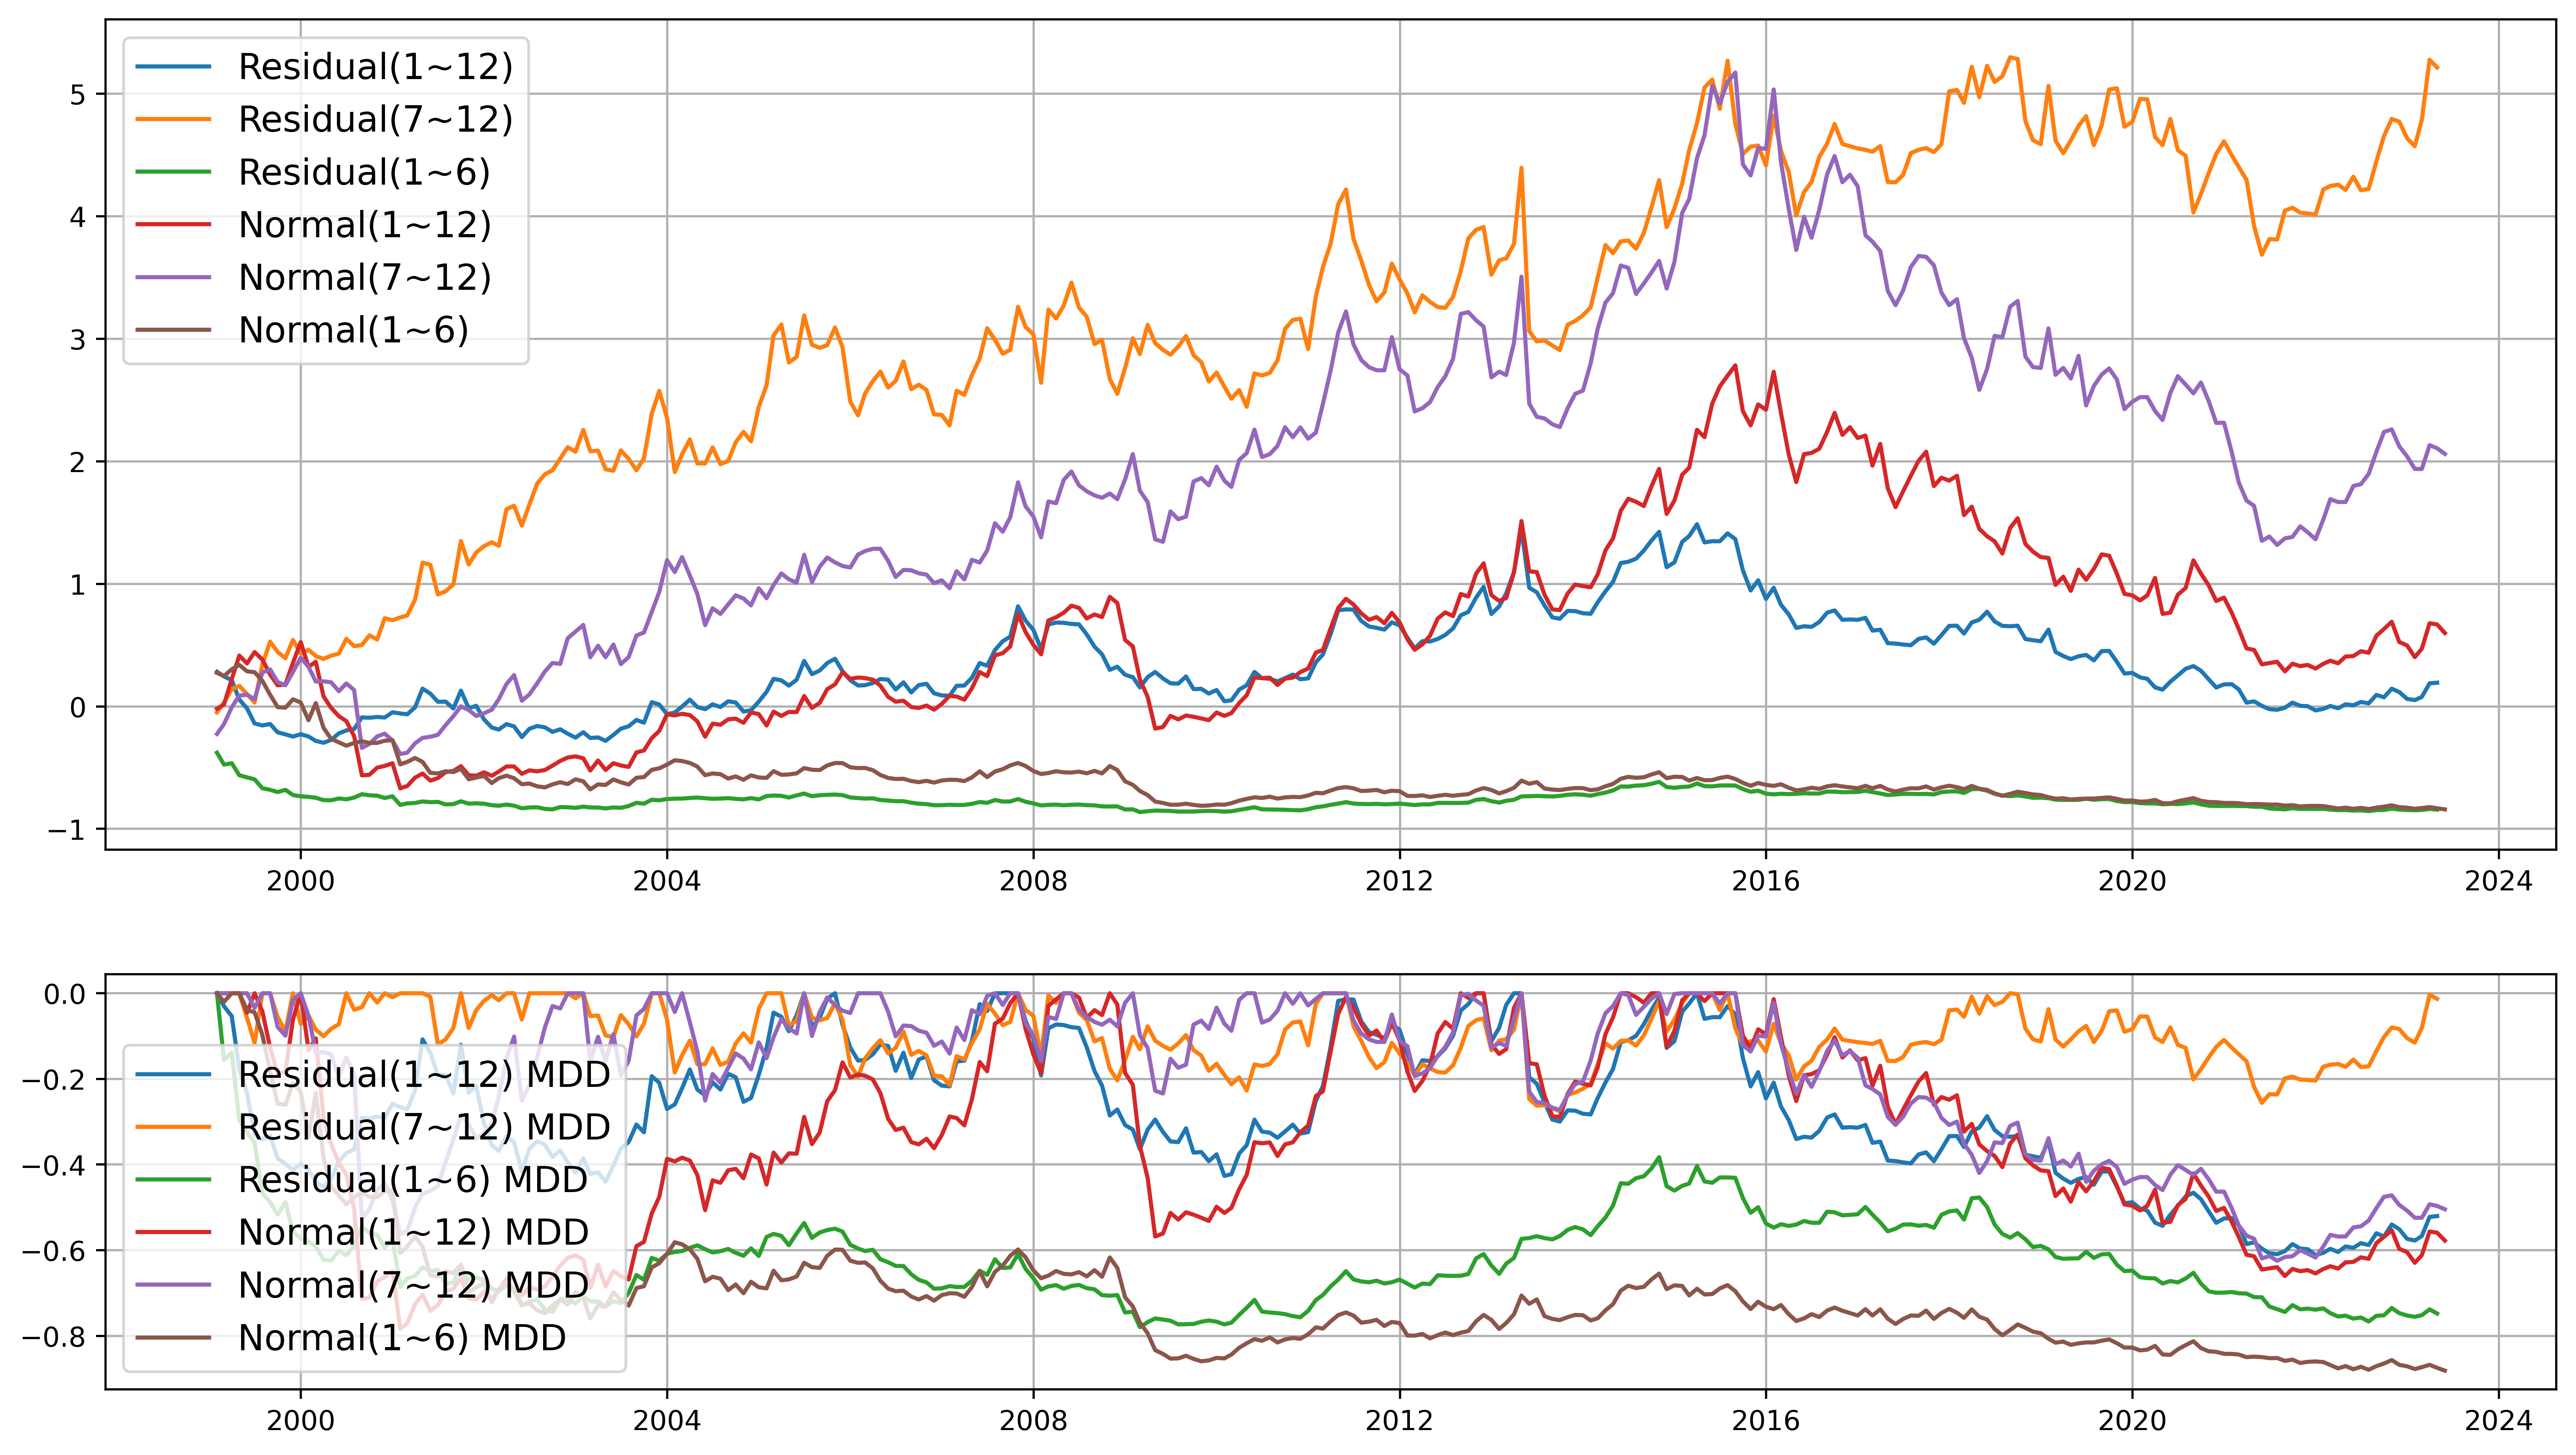

In [277]:
fig = plt.figure(figsize=(16,9), dpi=500)

spec = gridspec.GridSpec(ncols=1, nrows=2,
                         height_ratios=[2, 1])

ax0 = fig.add_subplot(spec[0])
#ax0.plot((resid_mom_ret + 1).cumprod()-1, label='Residual Zero Port PNL')
#ax0.plot((mom_pnl.loc[resid_mom_ret.index[0]:, 'mom_pnl']+1).cumprod()-1, label='Normal Mom Zero Port PNL')
ax0.plot(resid_mon_cum_all)
ax0.plot(resid_mon_cum_long)
ax0.plot(resid_mon_cum_short.loc[residcum_all.index[0]:])
ax0.plot(mom_cum_all)
ax0.plot(mom_cum_long)
ax0.plot(mom_cum_short.loc[mom_cum_all.index[0]:])
ax0.grid()
ax0.legend(['Residual(1~12)', 'Residual(7~12)', 'Residual(1~6)', 'Normal(1~12)', 'Normal(7~12)', 'Normal(1~6)'], fontsize=13)

ax1 = fig.add_subplot(spec[1])
ax1.plot(cal_mdd(resid_mom_ret_all))
ax1.plot(cal_mdd(resid_mom_ret_long))
ax1.plot(cal_mdd(resid_mom_ret_short.loc[residcum_all.index[0]:]))
ax1.plot(cal_mdd(mom_pnl_all.iloc[:,0].loc[residcum_all.index[0]:]))
ax1.plot(cal_mdd(mom_pnl_long.iloc[:,0].loc[residcum_all.index[0]:]))
ax1.plot(cal_mdd(mom_pnl_short.iloc[:,0].loc[residcum_all.index[0]:]))
ax1.legend(['Residual(1~12) MDD', 'Residual(7~12) MDD', 'Residual(1~6) MDD', 'Normal(1~12) MDD', 'Normal(7~12) MDD', 'Normal(1~6) MDD'], fontsize=13)
ax1.grid()

fig.show()


# 횡단면 분석

In [288]:
def cal_decile_index (series, lower, upper):
    a = series.dropna()
    return a[ (a >= a.quantile(lower)) & (a < a.quantile(upper))].index.to_list()

# Dependent

## s 는 Short term Residual 이엇고, l 은 Long term residual 임

In [459]:
''' short residual 시그널을 가지고 정렬한 다음에, 그 내의 주식들을 과거 수익률 변수값을 기준으로 정렬해 5등분 다시한다.'''

s5 = resid_standard_short.loc['1999-01-31':].apply(lambda x: cal_decile_index(x, 0.8, 1.0), axis=1).to_frame()
s4 = resid_standard_short.loc['1999-01-31':].apply(lambda x: cal_decile_index(x, 0.6, 0.8), axis=1).to_frame()
s3 = resid_standard_short.loc['1999-01-31':].apply(lambda x: cal_decile_index(x, 0.4, 0.6), axis=1).to_frame()
s2 = resid_standard_short.loc['1999-01-31':].apply(lambda x: cal_decile_index(x, 0.2, 0.4), axis=1).to_frame()
s1 = resid_standard_short.loc['1999-01-31':].apply(lambda x: cal_decile_index(x, 0.0, 0.2), axis=1).to_frame()

reg_m    = pd.DataFrame(index=['s1','s2','s3','s4','s5'], columns=['l1', 'l2', 'l3', 'l4', 'l5'] )
reg_t    = pd.DataFrame(index=['s1','s2','s3','s4','s5'], columns=['l1', 'l2', 'l3', 'l4', 'l5'] )

ind_list = [s1, s2, s3, s4, s5]
ind_name_list = ['s1', 's2', 's3', 's4', 's5']

for main_sort_df, main_sort_name in zip(ind_list, ind_name_list):
    
    for mul in range(0, 5):
        
        d1d1 = []
        date_list = []

        for idx in main_sort_df.index[:-1]:
            
            series = main_sort_df.loc[idx]
            date = series.name
            tick = series.item()

            ivst_date = monthly_ret.index[np.where(monthly_ret.index == date)[0]+1]
            
            check = resid_standard_long.loc[date,tick].dropna()
            
            index = cal_decile_index(check, mul * 0.2, (mul+1) * 0.2)
            
            ret = monthly_ret.loc[ivst_date, index].mean(axis=1).item()
            
            d1d1.append(ret)
            date_list.append(ivst_date[0])
            
        tmp_df = pd.DataFrame(data=d1d1, index=date_list, columns=['d1d1'])

        mu = tmp_df.mean()
        t = tmp_df.mean()/tmp_df.std() * np.sqrt(len(tmp_df))
        
        reg_m.at[main_sort_name, f'l{mul+1}'] = mu.item()
        reg_t.at[main_sort_name, f'l{mul+1}'] = t.item()


reg_t

,l1,l2,l3,l4,l5
s1,1.97029,2.68959,2.002754,2.816494,3.280715
s2,2.490565,1.833736,2.74796,3.51985,3.134751
s3,2.004008,2.724315,3.074457,2.641192,2.810342
s4,1.194601,3.150555,2.314337,2.272572,2.443206
s5,1.772523,2.999254,1.458543,1.598649,2.693688


In [460]:
reg_m * 100

,l1,l2,l3,l4,l5
s1,0.884218,1.253353,0.965525,1.452764,1.749841
s2,1.282418,0.820691,1.226272,1.805988,1.647471
s3,0.92917,1.50883,1.386648,1.289581,1.413527
s4,0.561731,1.412358,1.146823,1.020328,1.208048
s5,0.945327,1.488602,0.699241,0.837919,1.426278


## pret(12,7) 이랑 일반 모멘텀 비교

In [470]:
''' short residual 시그널을 가지고 정렬한 다음에, 그 내의 주식들을 과거 수익률 변수값을 기준으로 정렬해 5등분 다시한다.'''

'''df_mom_1 바꾸고''' 

m5 = df_mom_1.loc['1999-01-31':].apply(lambda x: cal_decile_index(x, 0.8, 1.0), axis=1).to_frame()
m4 = df_mom_1.loc['1999-01-31':].apply(lambda x: cal_decile_index(x, 0.6, 0.8), axis=1).to_frame()
m3 = df_mom_1.loc['1999-01-31':].apply(lambda x: cal_decile_index(x, 0.4, 0.6), axis=1).to_frame()
m2 = df_mom_1.loc['1999-01-31':].apply(lambda x: cal_decile_index(x, 0.2, 0.4), axis=1).to_frame()
m1 = df_mom_1.loc['1999-01-31':].apply(lambda x: cal_decile_index(x, 0.0, 0.2), axis=1).to_frame()

reg_m    = pd.DataFrame(index=['m1','m2','m3','m4','m5'], columns=['l1', 'l2', 'l3', 'l4', 'l5'] )
reg_t    = pd.DataFrame(index=['m1','m2','m3','m4','m5'], columns=['l1', 'l2', 'l3', 'l4', 'l5'] )

ind_list = [m1, m2, m3, m4, m5]
ind_name_list = ['m1', 'm2', 'm3', 'm4', 'm5']

for main_sort_df, main_sort_name in zip(ind_list, ind_name_list):
    
    for mul in range(0, 5):
        
        d1d1 = []
        date_list = []

        for idx in main_sort_df.index[:-1]:
            
            series = main_sort_df.loc[idx]
            date = series.name
            tick = series.item()

            ivst_date = monthly_ret.index[np.where(monthly_ret.index == date)[0]+1]
            '''resid_standard_long을 사용하면 됨'''
            check = resid_standard_all.loc[date,tick].dropna()
            
            index = cal_decile_index(check, mul * 0.2, (mul+1) * 0.2)
            
            ret = monthly_ret.loc[ivst_date, index].mean(axis=1).item()
            
            d1d1.append(ret)
            date_list.append(ivst_date[0])
            
        tmp_df = pd.DataFrame(data=d1d1, index=date_list, columns=['d1d1'])

        mu = tmp_df.mean()
        t = tmp_df.mean()/tmp_df.std() * np.sqrt(len(tmp_df))
        
        reg_m.at[main_sort_name, f'l{mul+1}'] = mu.item()
        reg_t.at[main_sort_name, f'l{mul+1}'] = t.item()

reg_m

reg_t


,l1,l2,l3,l4,l5
m1,1.517573,2.083794,1.72482,0.446653,0.368113
m2,2.844989,1.805673,2.235192,2.167153,1.178464
m3,3.112668,2.722912,3.164442,2.982694,2.612611
m4,3.156986,3.176385,4.06603,2.804388,2.995589
m5,2.756711,2.756657,2.622884,1.521795,2.514269


In [471]:
reg_m * 100

,l1,l2,l3,l4,l5
m1,0.855386,1.268987,1.141295,0.250486,0.246543
m2,1.22084,0.849665,1.033094,1.067232,0.658575
m3,1.242453,1.139652,1.52307,1.310787,1.411011
m4,1.341058,1.389768,1.984548,1.326558,1.448616
m5,1.295314,1.397333,1.460686,0.847811,1.359978


# Indepedent

## Long Momentum 이랑 Long Residual Momentum 비교

In [608]:
'''변수 순서 (5가 큰거, m이 들어간 값이 인덱스로, s가 칼럼으로 가야만 함'''

m5 = df_mom_2.loc['1999-01-31':].apply(lambda x: cal_decile_index(x, 0.8, 1.0), axis=1).to_frame()
m4 = df_mom_2.loc['1999-01-31':].apply(lambda x: cal_decile_index(x, 0.6, 0.8), axis=1).to_frame()
m3 = df_mom_2.loc['1999-01-31':].apply(lambda x: cal_decile_index(x, 0.4, 0.6), axis=1).to_frame()
m2 = df_mom_2.loc['1999-01-31':].apply(lambda x: cal_decile_index(x, 0.2, 0.4), axis=1).to_frame()
m1 = df_mom_2.loc['1999-01-31':].apply(lambda x: cal_decile_index(x, 0.0, 0.2), axis=1).to_frame()

s5 = resid_standard_long.loc['1999-01-31':].apply(lambda x: cal_decile_index(x, 0.8, 1.0), axis=1).to_frame()
s4 = resid_standard_long.loc['1999-01-31':].apply(lambda x: cal_decile_index(x, 0.6, 0.8), axis=1).to_frame()
s3 = resid_standard_long.loc['1999-01-31':].apply(lambda x: cal_decile_index(x, 0.4, 0.6), axis=1).to_frame()
s2 = resid_standard_long.loc['1999-01-31':].apply(lambda x: cal_decile_index(x, 0.2, 0.4), axis=1).to_frame()
s1 = resid_standard_long.loc['1999-01-31':].apply(lambda x: cal_decile_index(x, 0.0, 0.2), axis=1).to_frame()


reg_m = pd.DataFrame(index=['m1', 'm2', 'm3', 'm4', 'm5'], columns=['s1', 's2', 's3', 's4', 's5'])
reg_t = pd.DataFrame(index=['m1', 'm2', 'm3', 'm4', 'm5'], columns=['s1', 's2', 's3', 's4', 's5'])

for x in range(1, 6):
    
    for y in range(1, 6):
        
        tttt = pd.concat([ globals()[f'm{x}'], globals()[f's{y}'] ], axis=1)

        ivst_list = []
        mean_ret_list = []

        for idx in tttt.index:
            '''수익률 계산이니 안건들여도 됨'''
            ticks = list(set(tttt.loc[idx].iloc[0]) & set(tttt.loc[idx].iloc[1]))
            date = series.name
            ivst_date = monthly_ret.index[np.where(monthly_ret.index==date)[0]+1][0]
            
            ret = monthly_ret.loc[ivst_date, ticks].mean()
            
            mean_ret_list.append(ret)
            ivst_list.append(ivst_date)

        tmp_df = pd.DataFrame(index=ivst_list, data=mean_ret_list)

        mu = tmp_df.mean().item()
        t_value = (tmp_df.mean()/tmp_df.std() * np.sqrt(len(tmp_df))).item()

        reg_m.at[f'm{x}', f's{y}'] = mu
        reg_t.at[f'm{x}', f's{y}'] = t_value
        
reg_m * 100

,s1,s2,s3,s4,s5
m1,1.935118,1.79872,1.303546,1.379093,3.562499
m2,1.879565,1.700639,1.773496,1.784463,1.656665
m3,1.255405,1.135066,1.473551,1.819331,1.814788
m4,0.73363,0.780262,1.172345,1.316358,1.328544
m5,-0.128909,0.227593,0.60259,1.772456,1.662481


오 s가 레지듀얼인데, 레지듀얼이 큰값으로 가짐. 괜찮은 시그널이당,

In [609]:
reg_t

,s1,s2,s3,s4,s5
m1,13.925711,9.951135,3.952137,2.472924,4.266744
m2,12.684424,13.301103,9.273591,4.82859,2.988338
m3,5.514271,7.122372,9.525821,9.772006,4.766967
m4,2.141119,2.791243,7.405527,10.175121,4.760521
m5,-0.218999,0.486581,1.60098,10.267413,13.961621
